# Moving Average

Trains model on synthetic data .

In [1]:
import sys
sys.path.append('../..')


In [2]:
from model_compra_comigo.data_handler import DataSimulator
from model_compra_comigo.data_handler import DataHandler
import tensorflow as tf
from numpy import arange
import tensorflow_datasets as tfds
import numpy as np


2023-07-12 11:20:11.560909: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 11:20:11.660440: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 11:20:11.661086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 11:20:12.582726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data_simulator = DataSimulator()
data_handler = DataHandler()


## Generate a Dataset

{"levelname": "WARNING", "asctime": "2023-07-12 11:20:14,281", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


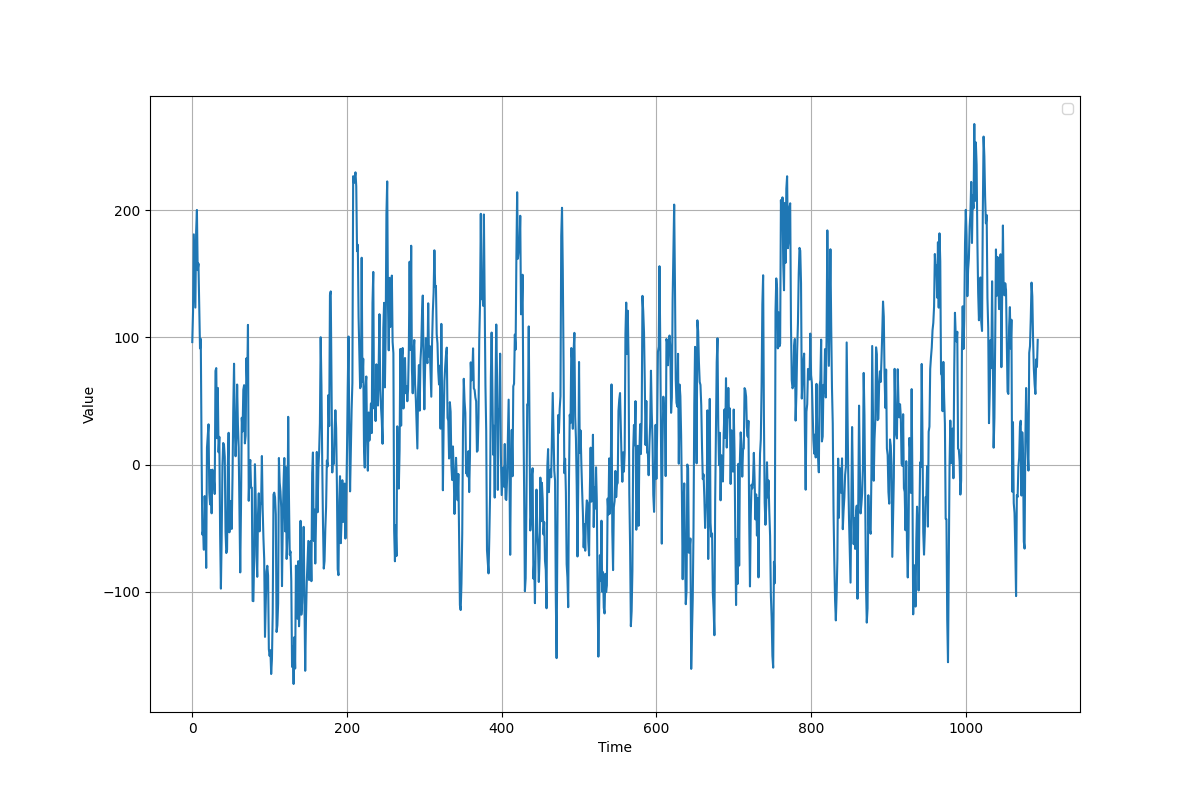

In [4]:
data_simulator = DataSimulator()
time_range = 365*3
time_data = arange(time_range)
split = int(365*2)


series, parameters = data_simulator.generate(
    time_range = time_range,
)

labels=[(f"trend_slope = {parameters['trend_slope']}\n"
         f"seasonality_period = {parameters['seasonality_period']}\n"
         f"seasonality_amplitude = {parameters['seasonality_amplitude']}\n"
         f"seasonality_phase = {parameters['seasonality_phase']}\n"
         f"seasonality_time_threshold = {parameters['seasonality_time_threshold']}\n"
         f"seasonality_ncos = {parameters['seasonality_ncos']}\n"
         f"seasonality_nexp = {parameters['seasonality_nexp']}\n"
         f"noise_scaling_factor = {parameters['noise_scaling_factor']}\n"
         f"autocorrelation_amplitude = {parameters['autocorrelation_amplitude']}\n"
         f"autocorrelation_phi = {parameters['autocorrelation_phi']}"
        )]

data_handler.plot_series(
    time=time_data,
    series=series,
    labels=labels
)


# Trains and tests some models
Experimentation

In [5]:
import sys
sys.path.append('..')

## Naive Models


### Moving Average
Naive "Model" using only Moving Average (used as a possible baseline model to compare the performance of others)

In [6]:
from model_compra_comigo.model import MovingAverageModel
model = MovingAverageModel()

window_size=30


In [7]:
x_valid = series
x_predict = model.predict(data=x_valid, window_size=window_size)
x_predict.shape


(1066,)

In [8]:
print(tf.keras.metrics.mean_squared_error(x_valid[window_size-1:], x_predict).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[window_size-1:], x_predict).numpy())

4878.55757765678
54.91352771774853


{"levelname": "WARNING", "asctime": "2023-07-12 11:20:14,594", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


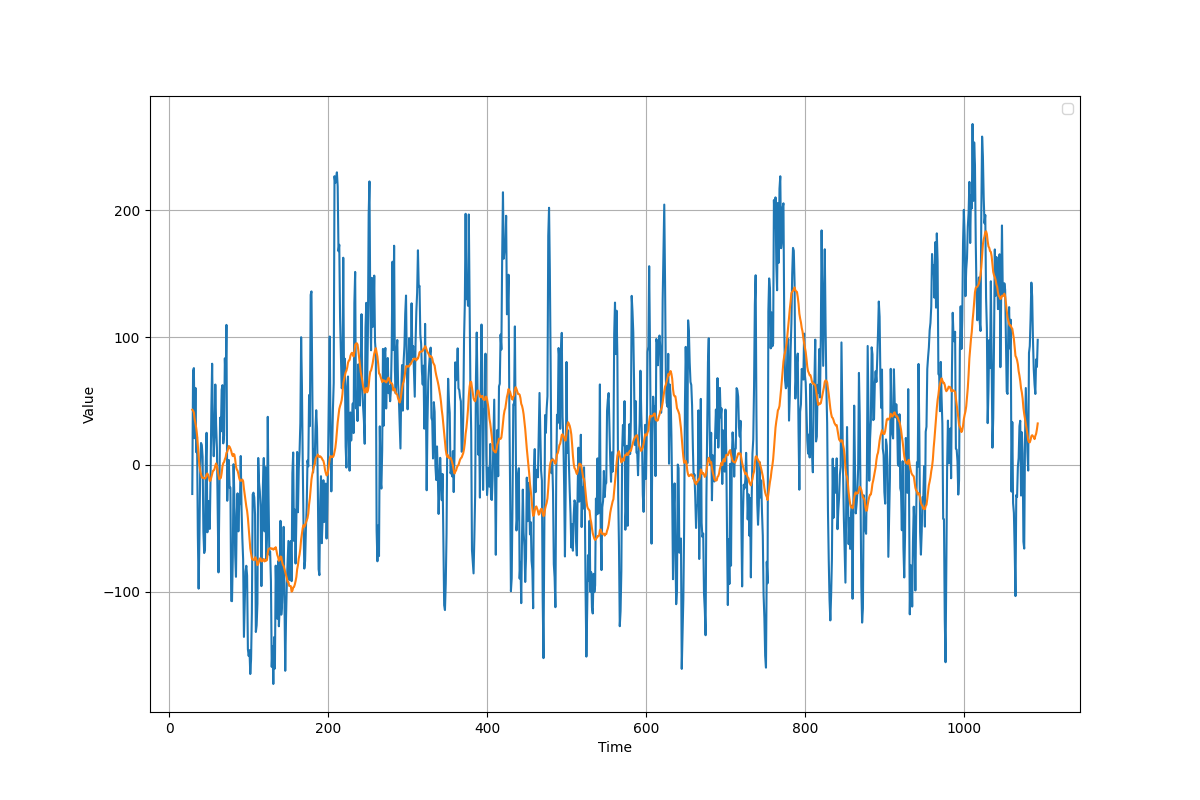

In [9]:
data_handler.plot_series(time_data[window_size-1:], (x_valid[window_size-1:], x_predict))

{"levelname": "WARNING", "asctime": "2023-07-12 11:20:14,733", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


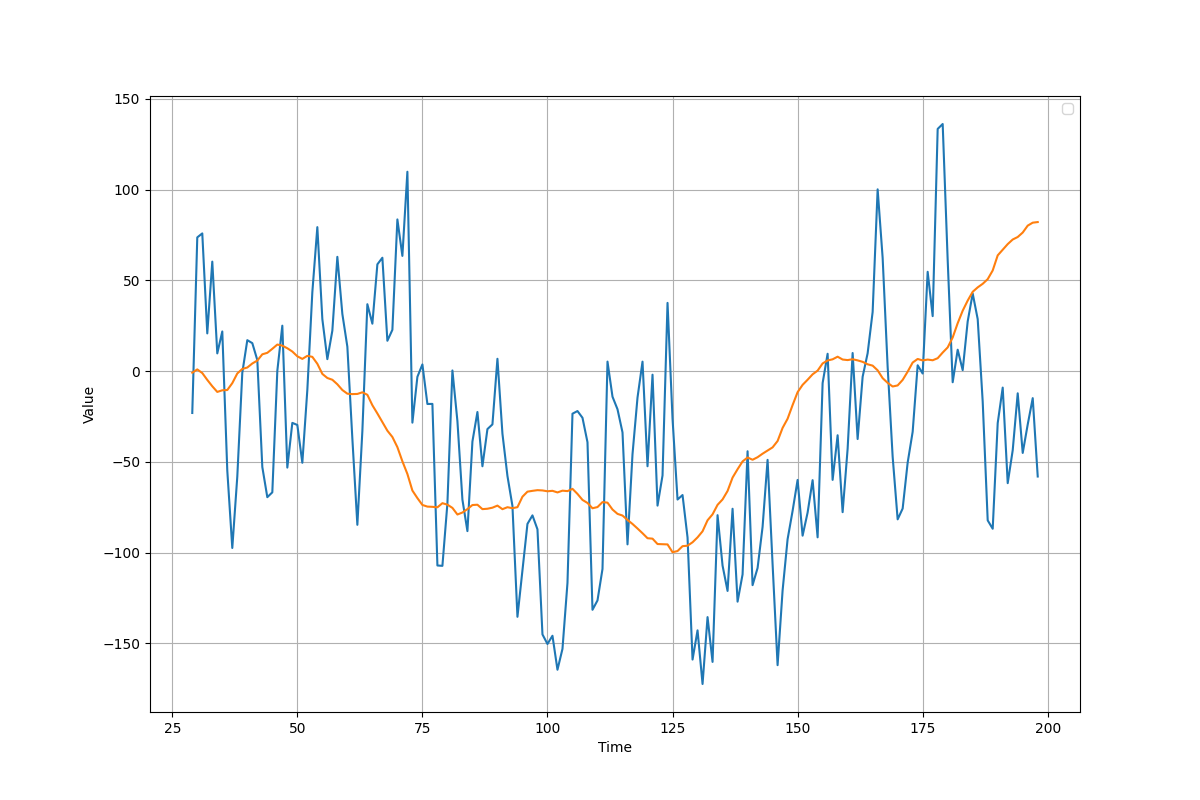

In [10]:
offset = (window_size-1)
start = 0
end = 200

data_handler.plot_series(
    time_data[start+offset:end], 
    (x_valid[start+offset:end], 
     x_predict[offset:end])
)

In [11]:
from model_compra_comigo.data_handler import DataHandler
dh = DataHandler()

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
split = 365*2

In [12]:
x_data = dh.generate_windowed_dataset(
    data=series[:split],
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer_size=shuffle_buffer_size
)

In [13]:
for windows in x_data.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

2023-07-12 11:20:14.905809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [730]
	 [[{{node Placeholder/_0}}]]
2023-07-12 11:20:14.905964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [730]
	 [[{{node Placeholder/_0}}]]


data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32, 1)


In [14]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.06762633],
       [-0.29467732],
       [ 0.10875022],
       [-0.0262    ],
       [-0.523399  ],
       [-0.5119526 ],
       [ 0.2851705 ],
       [ 0.00348932],
       [-0.32958275],
       [ 0.2146694 ],
       [ 0.3582378 ],
       [-0.5012336 ],
       [ 0.41165304],
       [-0.15666199],
       [ 0.24245477],
       [ 0.08249122],
       [ 0.49386793],
       [ 0.11890876],
       [ 0.3028558 ],
       [-0.4021387 ]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))

In [16]:
model.fit(x_data,epochs=100)

Epoch 1/100


2023-07-12 11:20:14.988322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [730]
	 [[{{node Placeholder/_0}}]]
2023-07-12 11:20:14.988472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [730]
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 0s 8ms/step - loss: 10368.3477
Epoch 2/100
23/23 [==============================] - 0s 845us/step - loss: 6486.1191
Epoch 3/100
23/23 [==============================] - 0s 914us/step - loss: 5215.8833
Epoch 4/100
23/23 [==============================] - 0s 866us/step - loss: 4566.2817
Epoch 5/100
23/23 [==============================] - 0s 878us/step - loss: 4103.2510
Epoch 6/100
23/23 [==============================] - 0s 809us/step - loss: 3764.2900
Epoch 7/100
23/23 [==============================] - 0s 846us/step - loss: 3500.2876
Epoch 8/100
23/23 [==============================] - 0s 795us/step - loss: 3290.3296
Epoch 9/100
23/23 [==============================] - 0s 889us/step - loss: 3120.1599
Epoch 10/100
23/23 [==============================] - 0s 789us/step - loss: 2979.7288
Epoch 11/100
23/23 [==============================] - 0s 785us/step - loss: 2862.1897
Epoch 12/100
23/23 [==============================] - 0s 862us/step - loss: 

In [17]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split - window_size:]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


{"levelname": "WARNING", "asctime": "2023-07-12 11:20:44,032", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


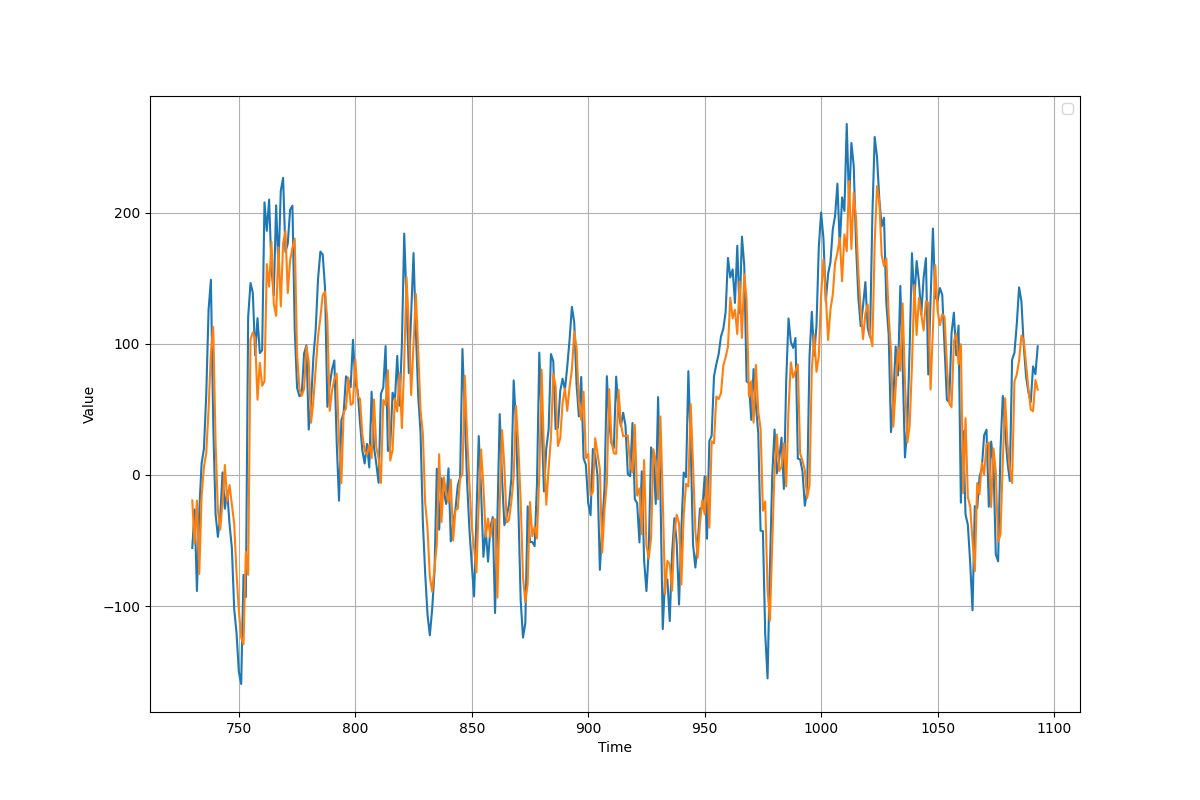

In [18]:
results = np.array(forecast).squeeze()
time_data[split:].shape, series.shape, results.shape
data_handler.plot_series(time_data[split:], (x_valid[split:], results))

In [19]:
print(tf.keras.metrics.mean_squared_error(x_valid[split:], results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[split:], results).numpy())


1946.0616
35.37143


Previous Result (Nice images)

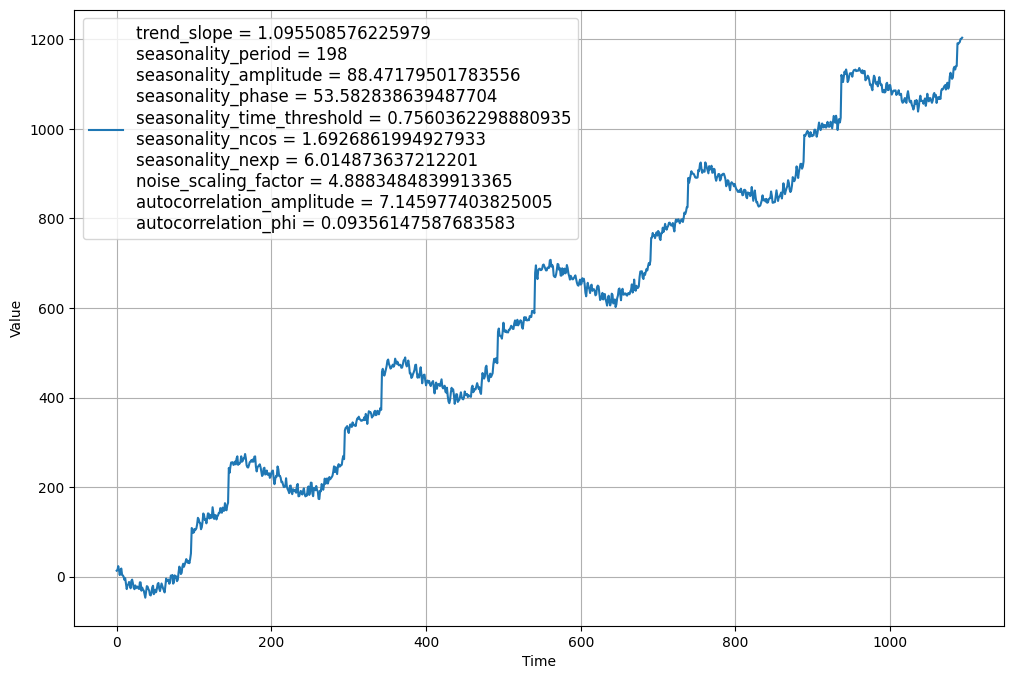
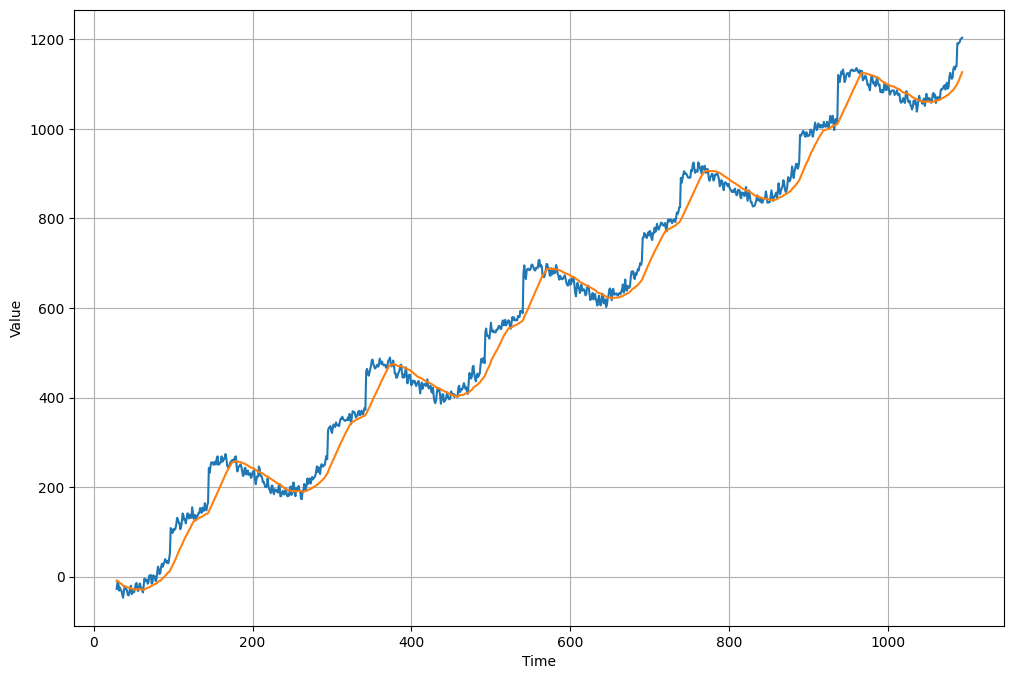

## Predict with n forecast

In [20]:
time_range = 365
time_data = arange(time_range)
series = series[:365]
batch_size = 15


In [21]:
nforecast = 30

In [22]:
data_f = data_handler.generate_windowed_data_forecast(
    data = series,
    window_size = window_size,
    batch_size = batch_size,
)

In [23]:
model = MovingAverageModel()

prediction = model.predict_batch(        
    data=data_f,
    window_size=window_size,
    nforecast=nforecast
)
prediction.shape

2023-07-12 11:20:44.189571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [365]
	 [[{{node Placeholder/_0}}]]
2023-07-12 11:20:44.189741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [365]
	 [[{{node Placeholder/_0}}]]


(346, 30)

In [24]:
from model_compra_comigo.data_handler import Visualizer

visualizer = Visualizer()


In [25]:
plots = visualizer.create_gif(
    time_data=time_data,
    series=series,
    forecast=prediction,
    batch_size=batch_size,
    window_size=window_size,
    nforecast=nforecast,
    gif_window=70
)


In [26]:
plots[0].save('./tmp/moving_average.gif',
             save_all = True, append_images = plots[1:], 
             optimize = False, duration = 100)
